# Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [941]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [942]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'


#data_file = 'factored_dataset.csv'
data_file = 'normalized_dataset.csv'
#data_file = 'standardized_normalized_dataset.csv'

data = pd.read_csv(file_dir + data_file)


In [943]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


In [944]:
data.shape

(1584, 12)

In [945]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.1, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 11 features


# Regression with Feature Selection

In [946]:
# -- trying
#selector = feature_selection.SelectKBest(feature_selection.f_regression).fit(x_train, y_train)
#selectedFeatures = selector.transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [947]:
#clf = LassoCV()
#sfm = SelectFromModel(clf) #(clf, threshold=0.01)
#selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [948]:
clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)
sfm = SelectFromModel(clf,threshold='0.8*mean')

In [949]:
# start:  search grid

reg = LinearRegression(normalize=False) # normalize false bacause we are going to use the scaler

# standardize the features
scaler = StandardScaler()
#scaler.fit(x_train.values.reshape(-1,n_features))

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('selector', sfm), 
    ('clf', reg)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'selector__threshold': [.1, .05, .02, .01, .005, 0.001]
}

search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                     

In [950]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])


Best CV score = -0.018:
Best CV params = {'selector__threshold': 0.1}

[-0.01669669 -0.0163372  -0.01596509 -0.01594819 -0.01594819 -0.01594819]


# Training R2

In [951]:
y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

#print("score ", search.score(x_test, y_test))
# or also R-Squared could be obtain via
#pline.score(x_train, y_train)

R2 (training) = 0.2959540207750059


In [952]:
print('R2 (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = -0.016763889103474223


In [953]:
pline.named_steps.regression.intercept_

0.6261804592123861

In [954]:
pline.named_steps.regression.coef_

array([ 0.02370634, -0.01899422,  0.07377199])

In [955]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.11 (0.07) 0.00 0.50 MSE


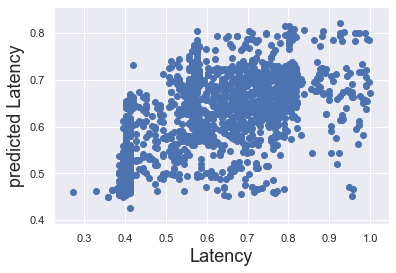

In [956]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

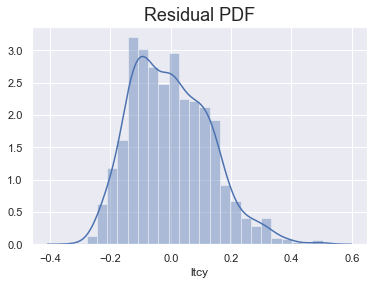

In [957]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [958]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

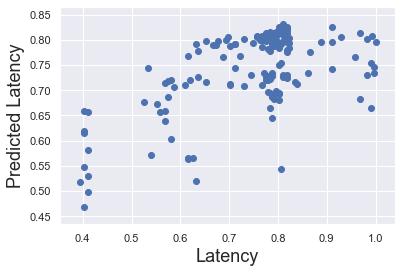

In [959]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [960]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,2.056,1.788
1,2.231,2.256
2,2.040,2.018
3,2.199,2.018
4,2.217,2.219


In [961]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,2.056,1.788,0.267,14.959
1,2.231,2.256,-0.026,1.143
2,2.040,2.018,0.022,1.088
3,2.199,2.018,0.180,8.928
4,2.217,2.219,-0.002,0.082
...,...,...,...,...
154,2.227,1.999,0.228,11.404
155,2.186,2.181,0.005,0.227
156,2.071,2.181,-0.110,5.045
157,2.238,2.134,0.104,4.867


In [962]:
perf.describe()

,prediction,target,residual,difference%
count,159.000,159.000,159.000,159.000
mean,2.109,2.130,-0.021,7.784
std,0.157,0.272,0.223,6.952
min,1.596,1.483,-0.748,0.058
25%,2.035,2.004,-0.121,1.927
50%,2.175,2.200,0.006,5.724
75%,2.226,2.247,0.102,11.568
max,2.298,2.718,0.436,29.121


In [963]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
46,2.22,2.22,0.00,0.06
71,2.25,2.25,0.00,0.08
4,2.22,2.22,-0.00,0.08
91,2.27,2.27,0.00,0.16
32,2.21,2.22,-0.00,0.18
155,2.19,2.18,0.00,0.23
24,2.22,2.22,0.01,0.23
37,2.26,2.26,0.01,0.24
58,2.21,2.20,0.01,0.25
74,2.26,2.26,0.01,0.34


# Prediction Accuracy

In [964]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.37633204810112664


In [965]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.1056905872529419


# Trying with Polynomial features 

In [966]:
if False:
    from sklearn.preprocessing import PolynomialFeatures

    # covert input data to polynomial form of some degree
    inputs_poly = PolynomialFeatures(degree=2).fit_transform(inputs).astype(float)

    x_train, x_test, y_train, y_test = \
        train_test_split(inputs_poly, targets, test_size=0.1, shuffle=False, random_state=365)

    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


    reg = LinearRegression(normalize=False) # normalize false bacause we are going to use the scaler

    scaler = StandardScaler()

    pipe = Pipeline(steps=[
        ('scaler', scaler),
        ('selector', sfm), 
        ('clf', reg)
    ])

    kfold = KFold(n_splits=10, shuffle=False)

    param_grid = {
        'selector__threshold': [.1, .05, .02, .01, .005, 0.001]
    }

    search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

    search.fit(x_train, y_train)

    y_hat_test = search.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))


# What features to select

In [967]:
x_train.shape

(1425, 11)

In [968]:
#clf = LassoCV()
#sfm = SelectFromModel(clf, threshold=0.001)

sfm = SelectFromModel(
                RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15),
                threshold='0.8*mean')

selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train[feature_list]
reduced_x_train.head(2)

4 features selected


,svc_cpu_thr,system_cpu_use,system_cpu_sat,svc_req_rate
0,0.33,16.98,1.59,0.98
1,0.30,20.58,1.61,1.62


# Robust Linear Model

In [969]:
# RANSAC is an iterative algorithm for the robust estimation of parameters from a subset 
# of inliers from the complete data set.
# you can use this with all dataset including outliers
if False:    
    from sklearn.linear_model import RANSACRegressor

    ransac = RANSACRegressor(estimator)
    ransac.fit(x_train, y_train)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    y_hat_test = ransac.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))